Reference links: 
- [1]https://www.pyimagesearch.com/2014/12/01/complete-guide-building-image-search-engine-python-opencv/

- [2]https://www.pinecone.io/learn/faiss-tutorial/#:~:text=Faiss%20is%20a%20library%20%E2%80%94%20developed,similar%20vectors%20within%20the%20index.

# IMAGE SEARCH

In [ ]:
# install faiss library
!pip install faiss-cpu

     |████████████████████████████████| 8.4 MB 26.7 MB/s 


In [ ]:
import os
import time
import imutils
import math
import faiss
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from IPython.display import clear_output
from google.colab import files
from imutils import paths

## Download files

In [ ]:
def download_from_gdrive(file_id, file_name):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget \
    --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
    'https://docs.google.com/uc?export=download&id=$file_id' -O- | \
    sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$file_id" \
    -O $file_name && rm -rf /tmp/cookies.txt
    clear_output(wait=True)

    print("{} downloaded!".format(file_name))

In [ ]:
# download dogs.zip file from google drive
download_from_gdrive("1zIgbo84K8TLh2SGg8wVlSEHLMv1O8Bgm", "dogs_subset.zip")
# unzig the dogs file
!unzip -qq dogs_subset.zip

dogs_subset.zip downloaded!


In [ ]:
# download the feature descriptor
download_from_gdrive("1E9aTJOB30GzQGgm5JmYiM6NwDf8v-PQi", "features_subset.csv")

features_subset.csv downloaded!


In [ ]:
# download the feature extractor model
download_from_gdrive("1--LMD8PVULJPkzFom2O8NTbQ-UMvpi_S", "feature_extractor_model_resnet.h5")

feature_extractor_model_resnet.h5 downloaded!


## Set paths

In [ ]:
# define file paths
FEATURES = "features_subset.csv"
MODEL_PATH = "feature_extractor_model_resnet.h5"
IMAGES = "output"

In [ ]:
# get all image paths
image_paths = list(paths.list_images(IMAGES))

## Feature Extractor

In [ ]:
class FeatureExtractor:
    def __init__(self, model):
        self.model = model

    def extract_features(self, image):
        # prepare image to pass through the model
        image = self.prepare_image(image)
        # get the features
        features = self.model(image)
        # convert to numpy and reshape
        features = features.numpy().reshape((-1,)) # reshape to (2048,)
        return features
        
    def prepare_image(self, image):
        # preprocess using model's preprocess_input func
        image = preprocess_input(image)
        # expand the dimension: (224, 224, 3) => (1, 224, 224, 3)
        image = np.expand_dims(image, axis=0)
        return image

### Code to extract & save features
```
from tqdm import tqdm

# load the feature extractor model
model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
# create an instance of FeatureExtractor class
fe = FeatureExtractor(model)

# get all the image paths
image_paths = paths.list_images(IMAGES)
# open the output index file for writing
output = open(FEATURES", "w")

added_ids = []
start = time.time()
for image_path in tqdm(image_paths):
    # extract the image ID
    # and load the image
    imageID = image_path.split("/")[1]
    if imageID not in added_ids:
        # read the image
        image = cv2.imread(image_path)

        # if image is not none: convert to RGB, resize and extract features
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
            # describe the image
            features = fe.extract_features(image)

            # write the features to file
            features = [str(f) for f in features]
            output.write("%s,%s\n" % (imageID, ",".join(features)))
            added_ids.append(imageID)


# close the index file
output.close()
print("Time taken {:.2f} mins".format((time.time() - start)/60))
```

## Load Model

In [ ]:
# load the feature extractor model
model = tf.keras.models.load_model(MODEL_PATH)
# create an instance of FeatureExtractor class
fe = FeatureExtractor(model)

## Create FAISS index

In [ ]:
# load the features data
df = pd.read_csv(FEATURES, header=None)

In [ ]:
# exclude AnimalInter-ID (first column)
features = df.iloc[:, 1:]
embeddings = features.values
# get embeddings shape
dim = embeddings.shape[1]
print("Dimension:", dim)

# convert to float32
embeddings = embeddings.astype(np.float32)

# initialize IndexFlatL2 index with our vector dimensionality
index = faiss.IndexFlatL2(dim)
# check whether an index needs to be trained using the is_trained method
print("is_trained?", index.is_trained)
# This will handle => ValueError: array is not C-contiguous
embeddings_fixed = embeddings.copy(order='C')

# load embeddings
index.add(embeddings_fixed)
print("total indices:",index.ntotal)

Dimension: 2048
is_trained? True
total indices: 5043


In [ ]:
faiss.write_index(index, 'faiss_index')

## Helper functions

In [ ]:
def get_features(image_path):
    """ Load and preprocess image."""
    query = cv2.imread(image_path)
    query = cv2.resize(query, (224, 224), interpolation=cv2.INTER_AREA)
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    features = fe.extract_features(query)
    return features, query

def load_image(imgpath):
    image = cv2.imread(imgpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = imutils.resize(image, width=200)
    return image

In [ ]:
index = faiss.read_index('faiss_index')

In [ ]:
new_df = df.rename(columns={0: 'dog_id'}).set_index('dog_id')
new_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
dog_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3979432,0.070021,0.216520,0.027097,0.150096,0.000000,0.401109,0.079990,0.305145,0.003982,0.016559,0.814126,0.000000,1.401750,0.109603,0.029817,2.149870,0.000000,1.209710,0.342710,0.152957,0.734517,0.565543,0.000000,0.438403,0.004835,0.194191,0.020188,0.552188,1.132499,0.212544,0.012066,0.895203,0.025163,0.296375,0.807629,1.269211,0.000000,0.160313,0.035443,1.363134,...,0.147117,0.640198,0.841365,0.655374,0.395282,0.913703,3.190170,0.273317,0.284264,0.619929,2.257286,0.013932,0.006279,0.105716,0.078138,0.483299,0.129384,0.071726,0.008174,0.162560,0.195750,0.036851,0.050650,0.183676,0.184711,0.465201,0.987488,0.000000,0.374259,0.137884,0.303920,1.008372,0.131830,0.242456,0.489774,0.022070,0.171523,0.916025,0.084787,2.214847
27541886,0.067230,0.155427,0.029047,0.281512,0.000551,0.237434,0.173810,1.187554,0.041911,0.000000,0.226731,0.088136,0.602266,0.243012,0.003763,4.055801,0.890548,0.000000,0.011131,0.048111,0.049024,0.136380,0.097299,0.720909,0.445374,0.271016,0.001405,0.189103,0.005577,1.162710,0.031029,0.399982,0.380389,0.375497,1.634553,1.714527,0.407285,0.415584,0.000000,0.079803,...,0.004876,1.146858,0.275053,0.043906,0.570347,0.553827,1.506777,0.248649,0.343520,0.861891,0.239697,0.000000,0.037877,0.136094,0.227292,0.272740,0.091513,0.074417,0.088089,0.547699,0.280352,0.326251,0.066254,0.330000,0.000000,0.575864,0.091506,0.000000,0.718044,0.422732,0.971852,0.035342,0.062317,0.165618,0.588662,0.395730,0.076263,0.560339,0.008621,1.101812
1506137,0.077279,0.073790,0.436448,0.259200,0.134229,1.267735,0.141642,0.335316,0.025757,0.110613,0.199126,0.117267,0.854532,0.145310,0.214911,0.263694,0.000000,1.153433,0.150643,0.977275,0.066222,0.088601,0.012086,0.247375,0.142581,0.308755,0.114966,0.114530,0.244939,1.021298,0.031434,0.026212,0.060278,0.175043,1.281538,1.340673,0.071590,0.232876,0.178966,0.565209,...,0.000000,0.094015,0.239748,0.424965,0.255282,0.146810,0.964852,0.527130,0.508531,0.817182,0.000000,0.248571,0.100962,0.423322,0.349864,0.005653,0.216322,0.603421,0.200671,1.278982,0.218066,0.210553,0.858580,1.143253,0.528640,0.298902,0.158078,0.024836,0.044218,0.082841,0.000000,0.295602,1.373063,0.485553,0.036241,0.181361,0.179424,0.711004,0.007506,1.110939
1487668,0.086909,0.231784,0.003545,1.460598,0.070518,2.342183,0.145685,0.535867,0.219405,0.145021,0.401321,0.134851,0.138921,0.055095,0.668100,0.001723,0.013827,1.927775,0.721453,0.137275,0.637669,0.057152,0.013870,0.181947,0.022525,1.394442,0.194939,0.615428,0.330203,0.312575,0.583249,1.269457,1.493734,0.245005,3.692797,0.419995,0.067014,1.354996,0.471788,4.115295,...,0.297529,0.348729,0.111890,0.054839,0.520624,0.740674,1.430611,0.643863,1.477170,0.133327,0.000000,0.186504,0.118582,1.085924,0.068242,0.148068,0.058175,0.222404,0.034914,1.207651,0.169408,0.000000,0.250092,0.823616,1.185253,0.428134,0.971349,0.189550,0.465519,0.103437,0.171442,0.052348,0.823935,0.047282,0.000000,0.032176,0.166784,0.173837,0.124691,1.645995
25641005,0.072395,0.118864,0.154019,0.000000,0.220544,0.457934,0.469139,0.024465,0.000000,0.003380,0.000000,0.056044,0.361619,0.974943,0.683950,0.070229,0.000000,0.040480,1.464409,0.015792,1.006068,0.540299,0.701553,0.425939,0.053483,0.074015,0.179178,1.726946,0.052538,0.025146,2.350522,0.788287,0.694738,0.084930,0.251170,1.020445,0.240636,0.126868,0.915471,1.268995,...,0.548590,1.217062,0.553481,1.150602,0.263254,0.207002,2.973079,0.122315,0.181123,0.562475,0.042306,0.102417,0.095008,0.047529,0.070488,0.052814,0.396348,0.059571,0.299277,3.059676,0.027870,1.041441,1.355334,0.189199,0.000000,1.186618,1.119883,0.002789,0.046019,0.320210,0.160802,1.370096,0.0630

In [ ]:
new_df.loc[3979432].

dtype('float64')

In [ ]:
new_df = new_df.astype(np.float32)

In [ ]:
test = pd.read_csv('features_subset_with_id.csv')
test.head()

,dog_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,3979432,0.070021,0.216520,0.027097,0.150096,0.000000,0.401109,0.079990,0.305145,0.003982,0.016559,0.814126,0.000000,1.401750,0.109603,0.029817,2.149870,0.000000,1.209710,0.342710,0.152957,0.734517,0.565543,0.000000,0.438403,0.004835,0.194191,0.020188,0.552188,1.132499,0.212544,0.012066,0.895203,0.025163,0.296375,0.807629,1.269211,0.000000,0.160313,0.035443,...,0.147117,0.640198,0.841365,0.655374,0.395282,0.913703,3.190170,0.273317,0.284264,0.619929,2.257286,0.013932,0.006279,0.105716,0.078138,0.483299,0.129384,0.071726,0.008174,0.162560,0.195750,0.036851,0.050650,0.183676,0.184711,0.465201,0.987488,0.000000,0.374259,0.137884,0.303920,1.008372,0.131830,0.242456,0.489774,0.022070,0.171523,0.916025,0.084787,2.214847
1,27541886,0.067230,0.155427,0.029047,0.281512,0.000551,0.237434,0.173810,1.187554,0.041911,0.000000,0.226731,0.088136,0.602266,0.243012,0.003763,4.055801,0.890548,0.000000,0.011131,0.048111,0.049024,0.136380,0.097299,0.720909,0.445374,0.271016,0.001405,0.189103,0.005577,1.162710,0.031029,0.399982,0.380389,0.375497,1.634553,1.714527,0.407285,0.415584,0.000000,...,0.004876,1.146858,0.275053,0.043906,0.570347,0.553827,1.506777,0.248649,0.343520,0.861891,0.239697,0.000000,0.037877,0.136094,0.227292,0.272740,0.091513,0.074417,0.088089,0.547699,0.280352,0.326251,0.066254,0.330000,0.000000,0.575864,0.091506,0.000000,0.718044,0.422732,0.971852,0.035342,0.062317,0.165618,0.588662,0.395730,0.076263,0.560339,0.008621,1.101812
2,1506137,0.077279,0.073790,0.436448,0.259200,0.134229,1.267735,0.141642,0.335316,0.025757,0.110613,0.199126,0.117267,0.854532,0.145310,0.214911,0.263694,0.000000,1.153433,0.150643,0.977275,0.066222,0.088601,0.012086,0.247375,0.142581,0.308755,0.114966,0.114530,0.244939,1.021298,0.031434,0.026212,0.060278,0.175043,1.281538,1.340673,0.071590,0.232876,0.178966,...,0.000000,0.094015,0.239748,0.424965,0.255282,0.146810,0.964852,0.527130,0.508531,0.817182,0.000000,0.248571,0.100962,0.423322,0.349864,0.005653,0.216322,0.603421,0.200671,1.278982,0.218066,0.210553,0.858580,1.143253,0.528640,0.298902,0.158078,0.024836,0.044218,0.082841,0.000000,0.295602,1.373063,0.485553,0.036241,0.181361,0.179424,0.711004,0.007506,1.110939
3,1487668,0.086909,0.231784,0.003545,1.460598,0.070518,2.342183,0.145685,0.535867,0.219405,0.145021,0.401321,0.134851,0.138921,0.055095,0.668100,0.001723,0.013827,1.927775,0.721453,0.137275,0.637669,0.057152,0.013870,0.181947,0.022525,1.394442,0.194939,0.615428,0.330203,0.312575,0.583249,1.269457,1.493734,0.245005,3.692797,0.419995,0.067014,1.354996,0.471788,...,0.297529,0.348729,0.111890,0.054839,0.520624,0.740674,1.430611,0.643863,1.477170,0.133327,0.000000,0.186504,0.118582,1.085924,0.068242,0.148068,0.058175,0.222404,0.034914,1.207651,0.169408,0.000000,0.250092,0.823616,1.185253,0.428134,0.971349,0.189550,0.465519,0.103437,0.171442,0.052348,0.823935,0.047282,0.000000,0.032176,0.166784,0.173837,0.124691,1.645995
4,25641005,0.072395,0.118864,0.154019,0.000000,0.220544,0.457934,0.469139,0.024465,0.000000,0.003380,0.000000,0.056044,0.361619,0.974943,0.683950,0.070229,0.000000,0.040480,1.464409,0.015792,1.006068,0.540299,0.701553,0.425939,0.053483,0.074015,0.179178,1.726946,0.052538,0.025146,2.350522,0.788287,0.694738,0.084930,0.251170,1.020445,0.240636,0.126868,0.915471,...,0.548590,1.217062,0.553481,1.150602,0.263254,0.207002,2.973079,0.122315,0.181123,0.562475,0.042306,0.102417,0.095008,0.047529,0.070488,0.052814,0.396348,0.059571,0.299277,3.059676,0.027870,1.041441,1.355334,0.189199,0.000000,1.186618,1.119883,0.002789,0.046019,0.320210,0.160802,1.370096,0.063004,0.234990,0.264727,0.053322,0.107844,0.215682,0.122659,1.056233


In [ ]:
new_df.to_csv('features_subset_with_id.csv')

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
0,3979432,0.070021,0.216520,0.027097,0.150096,0.000000,0.401109,0.079990,0.305145,0.003982,0.016559,0.814126,0.000000,1.401750,0.109603,0.029817,2.149870,0.000000,1.209710,0.342710,0.152957,0.734517,0.565543,0.000000,0.438403,0.004835,0.194191,0.020188,0.552188,1.132499,0.212544,0.012066,0.895203,0.025163,0.296375,0.807629,1.269211,0.000000,0.160313,0.035443,...,0.147117,0.640198,0.841365,0.655374,0.395282,0.913703,3.190170,0.273317,0.284264,0.619929,2.257286,0.013932,0.006279,0.105716,0.078138,0.483299,0.129384,0.071726,0.008174,0.162560,0.195750,0.036851,0.050650,0.183676,0.184711,0.465201,0.987488,0.000000,0.374259,0.137884,0.303920,1.008372,0.131830,0.242456,0.489774,0.022070,0.171523,0.916025,0.084787,2.214847
1,27541886,0.067230,0.155427,0.029047,0.281512,0.000551,0.237434,0.173810,1.187554,0.041911,0.000000,0.226731,0.088136,0.602266,0.243012,0.003763,4.055801,0.890548,0.000000,0.011131,0.048111,0.049024,0.136380,0.097299,0.720909,0.445374,0.271016,0.001405,0.189103,0.005577,1.162710,0.031029,0.399982,0.380389,0.375497,1.634553,1.714527,0.407285,0.415584,0.000000,...,0.004876,1.146858,0.275053,0.043906,0.570347,0.553827,1.506777,0.248649,0.343520,0.861891,0.239697,0.000000,0.037877,0.136094,0.227292,0.272740,0.091513,0.074417,0.088089,0.547699,0.280352,0.326251,0.066254,0.330000,0.000000,0.575864,0.091506,0.000000,0.718044,0.422732,0.971852,0.035342,0.062317,0.165618,0.588662,0.395730,0.076263,0.560339,0.008621,1.101812
2,1506137,0.077279,0.073790,0.436448,0.259200,0.134229,1.267735,0.141642,0.335316,0.025757,0.110613,0.199126,0.117267,0.854532,0.145310,0.214911,0.263694,0.000000,1.153433,0.150643,0.977275,0.066222,0.088601,0.012086,0.247375,0.142581,0.308755,0.114966,0.114530,0.244939,1.021298,0.031434,0.026212,0.060278,0.175043,1.281538,1.340673,0.071590,0.232876,0.178966,...,0.000000,0.094015,0.239748,0.424965,0.255282,0.146810,0.964852,0.527130,0.508531,0.817182,0.000000,0.248571,0.100962,0.423322,0.349864,0.005653,0.216322,0.603421,0.200671,1.278982,0.218066,0.210553,0.858580,1.143253,0.528640,0.298902,0.158078,0.024836,0.044218,0.082841,0.000000,0.295602,1.373063,0.485553,0.036241,0.181361,0.179424,0.711004,0.007506,1.110939
3,1487668,0.086909,0.231784,0.003545,1.460598,0.070518,2.342183,0.145685,0.535867,0.219405,0.145021,0.401321,0.134851,0.138921,0.055095,0.668100,0.001723,0.013827,1.927775,0.721453,0.137275,0.637669,0.057152,0.013870,0.181947,0.022525,1.394442,0.194939,0.615428,0.330203,0.312575,0.583249,1.269457,1.493734,0.245005,3.692797,0.419995,0.067014,1.354996,0.471788,...,0.297529,0.348729,0.111890,0.054839,0.520624,0.740674,1.430611,0.643863,1.477170,0.133327,0.000000,0.186504,0.118582,1.085924,0.068242,0.148068,0.058175,0.222404,0.034914,1.207651,0.169408,0.000000,0.250092,0.823616,1.185253,0.428134,0.971349,0.189550,0.465519,0.103437,0.171442,0.052348,0.823935,0.047282,0.000000,0.032176,0.166784,0.173837,0.124691,1.645995
4,25641005,0.072395,0.118864,0.154019,0.000000,0.220544,0.457934,0.469139,0.024465,0.000000,0.003380,0.000000,0.056044,0.361619,0.974943,0.683950,0.070229,0.000000,0.040480,1.464409,0.015792,1.006068,0.540299,0.701553,0.425939,0.053483,0.074015,0.179178,1.726946,0.052538,0.025146,2.350522,0.788287,0.694738,0.084930,0.251170,1.020445,0.240636,0.126868,0.915471,...,0.548590,1.217062,0.553481,1.150602,0.263254,0.207002,2.973079,0.122315,0.181123,0.562475,0.042306,0.102417,0.095008,0.047529,0.070488,0.052814,0.396348,0.059571,0.299277,3.059676,0.027870,1.041441,1.355334,0.189199,0.000000,1.186618,1.119883,0.002789,0.046019,0.320210,0.160802,1.370096,0.063004,0.234990,0.264727,0.053322,0.107844,0.215682,0.122659,1.056233


In [ ]:
def get_similar_ids(query_id, k):
    # load image
    xq = new_df.loc[query_id].astype(np.float32)
    # get query image id
    # queryID = query_image_path.split(os.path.sep)[1]
    # start tracking time
    start = time.time()
    D, I = index.search(np.array([xq]), k)
    print("Time taken to search: {:.2f}s".format(time.time() - start))
    # similar dogs ids
    similar_dog_ids = new_df.iloc[I[0]].values
    return similar_dog_ids

similar_dog_ids = get_similar_ids(25641005, 5)

Time taken to search: 0.02s


Text(0.5, 1.0, '3860545')

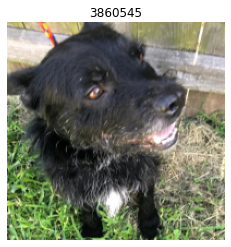

In [ ]:
img_paths = list(paths.list_images(os.path.join(IMAGES, str(25641005))))
image = load_image(img_paths[0])
plt.imshow(image)
plt.axis('off')
plt.title(str(id))

In [ ]:
similar_dog_ids

array([[7.2394930e-02, 1.1886419e-01, 1.5401931e-01, ..., 2.1568173e-01,
        1.2265861e-01, 1.0562327e+00],
       [2.8012468e-02, 3.2441989e-01, 0.0000000e+00, ..., 9.1940157e-02,
        1.4569432e-01, 8.4373260e-01],
       [1.4509681e-01, 5.7410163e-01, 2.6978906e-02, ..., 1.8164739e-02,
        1.3240656e-01, 9.9219924e-01],
       [2.5517505e-01, 3.2793751e-01, 3.2664680e-01, ..., 2.4840024e-01,
        4.4601537e-02, 2.9200876e+00],
       [1.5274817e-01, 1.8166630e-01, 6.6931522e-04, ..., 0.0000000e+00,
        3.4921646e-01, 5.2799708e-01]], dtype=float32)

In [ ]:
def show_similar_images(query_image_path, k):
    # load image
    xq, query_image = get_features(query_image_path)
    # get query image id
    # queryID = query_image_path.split(os.path.sep)[1]
    # start tracking time
    start = time.time()
    D, I = index.search(np.array([xq]), k)
    print("Time taken to search: {:.2f}s".format(time.time() - start))
    # similar dogs ids
    similar_dog_ids = df[0].iloc[I[0]].values

    # display query image
    plt.imshow(query_image)
    plt.axis("off")
    plt.title(f"Query Image", fontsize=18)
    plt.show()
    # create a figure object
    fig = plt.figure(figsize=(10, 6))
    # loop over the results and display the similar images
    for i, id in enumerate(similar_dog_ids):
        ax = fig.add_subplot(2, 5, i+1)
        img_paths = list(paths.list_images(os.path.join(IMAGES, str(id))))
        image = load_image(img_paths[0])
        plt.imshow(image)
        plt.axis('off')
        plt.title(str(id))
    plt.tight_layout()
    plt.suptitle("Similar Dogs\n", fontsize=16)
    plt.show()

## Upload images from local system and get similar dog images

Saving 5484d9d1eab8ea3017b17e29.jpeg to 5484d9d1eab8ea3017b17e29 (2).jpeg
Time taken to search: 0.02s


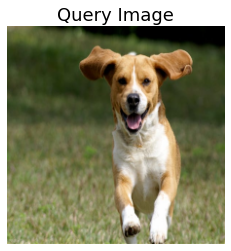

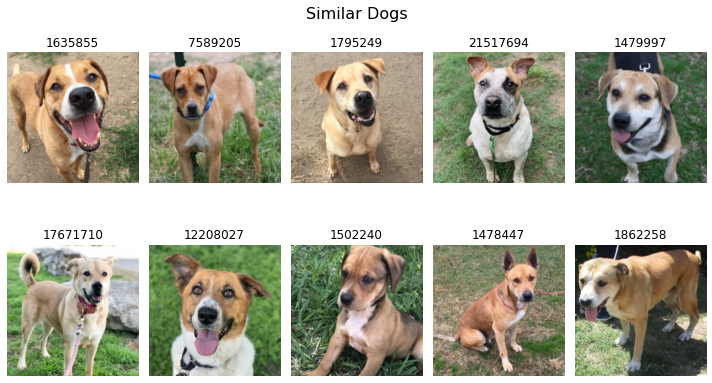

In [ ]:
# upload option
uploaded = files.upload()
show_similar_images(list(uploaded.keys())[0], k=10)